# 노선별 정류장 구간별 속도

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic", #"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

---

# 1) 데이터 로딩

## a. 시내버스 인가현황

In [17]:
bus_info = pd.read_excel('../../data/서울교통수단이동/master/시내버스 2022.11월 인가현황.xlsx')
bus_info.columns = list(map(lambda x: x.replace('\n', ''), bus_info.columns))

display(bus_info.head())
print('shape:', bus_info.shape)
print('유형:', bus_info['유형'].unique())

for bus_type in ['순환', '광역', '맞춤', '심야']:
    print(f'{bus_type}:', bus_info.loc[bus_info['유형'] == bus_type, '노선번호'].unique())

,업체명,노선번호,유형,기점,종점,인가대수,운행대수,예비대수,인가거리,운행시간,총운행횟수,최소,최대,첫차시간,막차시간
0,북부운수,1,순환,남산예장버스환승주차장,남산예장버스환승주차장,12,10,2,16.00,60,120,7,10,0630,2300
1,한성여객,100,간선,하계동,용산구청,30,28,2,57.09,231,112,8,12,0400,2230
2,동아운수,101,간선,우이동,서소문,23,22,1,37.81,170,119,5,11,0400,2300
3,한성운수,101,간선,우이동,서소문,9,8,1,37.81,165,41,6,12,0400,2300
4,삼화상운,102,간선,상계주공7단지,동대문,2,2,0,30.20,126,14,8,12,0400,2310


shape: (436, 15)
유형: ['순환' '간선' '지선' '맞춤' '광역' '심야']
순환: [1]
광역: [9401 9403 9404 9408 9409 9701 9703 9707 9711 9714]
맞춤: [8002 8003 8112 8221 8331 8441 8541 8551 8552 8761 8771 8772 8774 8777]
심야: ['N13상계' 'N13송파' 'N15사당' 'N15우이' 'N16도봉' 'N16온수' 'N26강서' 'N26중랑' 'N30'
 'N32' 'N34' 'N37송파' 'N37진관' 'N51시흥' 'N51하계' 'N61상계' 'N61양천' 'N62면목'
 'N62양천' 'N64강서' 'N64염곡' 'N72' 'N75신림' 'N75진관']


## b. 노선마스터 - TBIS_MS_ROUTE.csv

In [18]:
route_master = pd.read_csv('../../data/서울교통수단이동/202209/TR202100010001_00/TBIS_MS_ROUTE.csv')
route_master.head()

,ROUTE_ID,ROUTE_NM,ROUTE_TY,DSTNC
0,200000289,3002예약수원,경기,0.0
1,200000290,3007예약수원,경기,0.0
2,200000295,M5443예약수원,경기,0.0
3,200000296,5100예약수원,경기,0.0
4,200000297,8800예약수원,경기,0.0


## c. 정류장마스터 - TBIS_MS_STTN.csv

In [19]:
station_master = pd.read_csv('../../data/서울교통수단이동/202209/TR202100010001_00/TBIS_MS_STTN.csv', on_bad_lines='skip')
station_master.head()

,STTN_ID,STTN_NM,STTN_TY,STTN_NO,CRDNT_X,CRDNT_Y,BIT_INSTL_AT
0,164000621,달빛축제공원,일반차로,38621.0,126.630347,37.400547,미설치
1,164000623,e편한세상후문,일반차로,32063.0,126.618124,37.408392,미설치
2,164000624,재능대송도캠퍼스,일반차로,38622.0,126.660781,37.367194,미설치
3,164000625,재능대송도캠퍼스,일반차로,38623.0,126.660566,37.367038,미설치
4,164000626,e편한세상 정문,일반차로,38624.0,126.616301,37.410865,미설치


## d. 노선정류장노드마스터 - TBIS_MS_ROUTE_NODE.csv

In [20]:
route_node_master = pd.read_csv('../../data/서울교통수단이동/202209/TR202100010001_00/TBIS_MS_ROUTE_NODE.csv')
route_node_master.head()

,ROUTE_ID,STTN_ID,LINK_DSTNC_ACMTL,STTN_SN
0,212000003,211000277,490,6
1,212000003,211000271,480,7
2,212000003,211000031,550,8
3,212000003,211000030,360,9
4,212000003,211000029,250,10


## e. 일자별 시간대별 버스노선별 구간별 운행시간 - TPSS_ROUTE_SECTION_SPEED_H.csv

In [21]:
trip_time = pd.read_csv('../../data/서울교통수단이동/202209/TR202100010001_00/TPSS_ROUTE_SECTION_SPEED_H.csv')
trip_time = trip_time.loc[:, ['ROUTE_ID', 'FROM_STTN_SN', 'TO_STTN_SN', 'FROM_STTN_ID', 'TO_STTN_ID', 'TRIP_TIME_18H', 'TRIP_TIME_19H', 'TRIP_TIME_20H', 'TRIP_TIME_21H']]
display(trip_time.head())
display(trip_time.shape)

,ROUTE_ID,FROM_STTN_SN,TO_STTN_SN,FROM_STTN_ID,TO_STTN_ID,TRIP_TIME_18H,TRIP_TIME_19H,TRIP_TIME_20H,TRIP_TIME_21H
0,100100009,10,11,108000072,108000074,49,47,44,43
1,100100029,76,77,119000021,119000022,84,61,58,57
2,100100012,89,90,207000060,207000356,252,229,209,193
3,100100038,106,107,221000111,221000110,161,126,169,118
4,100100024,41,42,122000050,122000007,156,173,133,141


(79053, 9)

## f. 일자별 시간대별 버스노선별 정류장별 운행횟수 - TPSS_STA_ROUTE_INFO_H_TURN.csv

In [22]:
trip_turn = pd.read_csv('../../data/서울교통수단이동/202209/TR202100010001_00/TPSS_STA_ROUTE_INFO_H_TURN.csv')
trip_turn = trip_turn.loc[:, ['ROUTE_ID', 'STTN_SN', 'STTN_ID', 'CNT_18H', 'CNT_19H', 'CNT_20H', 'CNT_21H']]
trip_turn.fillna(0.0, inplace=True)
display(trip_turn.head())
display(trip_turn.shape)

,ROUTE_ID,STTN_SN,STTN_ID,CNT_18H,CNT_19H,CNT_20H,CNT_21H
0,111000014,6.0,111000925.0,5.0,5.0,5.0,6.0
1,111000012,124.0,218000625.0,3.0,3.0,5.0,4.0
2,111000012,143.0,218000653.0,2.0,3.0,5.0,5.0
3,111000012,163.0,111000013.0,3.0,3.0,4.0,5.0
4,111000014,12.0,111000213.0,5.0,5.0,5.0,6.0


(83062, 7)

# 2) 줄이기

In [23]:
# 필요한 버스 노선만 추출
bus_fit = set(map(str, bus_info.loc[bus_info['유형'] == '맞춤', '노선번호']))
print('맞춤버스:', bus_fit)

맞춤버스: {'8002', '8331', '8551', '8777', '8761', '8003', '8441', '8112', '8541', '8774', '8221', '8771', '8772', '8552'}


In [24]:
# 노선마스터와 합치기
trip_time = pd.merge(trip_time, route_master, on='ROUTE_ID')
trip_time.drop(columns=['DSTNC'], inplace=True)

trip_time = trip_time.loc[trip_time['ROUTE_TY'].isin(['간선', '지선'])]  # 간선, 지선 버스만
trip_time = trip_time.loc[trip_time['ROUTE_NM'].str[0] != 'N']         # 야간버스 제거
trip_time = trip_time.loc[~trip_time['ROUTE_NM'].isin(bus_fit)]        # 맞춤버스 제거
trip_time

,ROUTE_ID,FROM_STTN_SN,TO_STTN_SN,FROM_STTN_ID,TO_STTN_ID,TRIP_TIME_18H,TRIP_TIME_19H,TRIP_TIME_20H,TRIP_TIME_21H,ROUTE_NM,ROUTE_TY
0,100100009,10,11,108000072,108000074,49,47,44,43,104,간선
1,100100009,40,41,100000116,100000109,138,83,89,82,104,간선
2,100100009,30,31,101000046,101000023,457,452,261,298,104,간선
3,100100009,11,12,108000074,108000076,38,36,37,31,104,간선
4,100100009,63,64,108000109,108000371,33,34,35,28,104,간선
...,...,...,...,...,...,...,...,...,...,...,...
78482,100100139,30,31,108000111,108000062,196,173,176,147,1124,지선
78483,100100139,36,37,108000121,108000195,141,156,145,172,1124,지선
78484,100100139,18,19,108000156,108000154,111,99,116,67,1124,지선
78485,100100139,11,12,108000155,108000157,129,115,110,143,1124,지선


# 3) 합치기

In [25]:
trip_speed = pd.merge(trip_time, trip_turn, left_on=['ROUTE_ID', 'TO_STTN_ID', 'TO_STTN_SN'], right_on=['ROUTE_ID', 'STTN_ID', 'STTN_SN'])
trip_speed.drop(columns=['STTN_ID', 'STTN_SN'], inplace=True)

trip_speed = pd.merge(trip_speed, route_node_master, left_on=['ROUTE_ID', 'TO_STTN_ID', 'TO_STTN_SN'], right_on=['ROUTE_ID', 'STTN_ID', 'STTN_SN'])
trip_speed.drop(columns=['STTN_ID', 'STTN_SN'], inplace=True)

trip_speed.head()

,ROUTE_ID,FROM_STTN_SN,TO_STTN_SN,FROM_STTN_ID,TO_STTN_ID,TRIP_TIME_18H,TRIP_TIME_19H,TRIP_TIME_20H,TRIP_TIME_21H,ROUTE_NM,ROUTE_TY,CNT_18H,CNT_19H,CNT_20H,CNT_21H,LINK_DSTNC_ACMTL
0,100100009,10,11,108000072,108000074,49,47,44,43,104,간선,6.0,7.0,8.0,8.0,264
1,100100009,40,41,100000116,100000109,138,83,89,82,104,간선,8.0,7.0,9.0,6.0,262
2,100100009,30,31,101000046,101000023,457,452,261,298,104,간선,7.0,7.0,7.0,8.0,1661
3,100100009,11,12,108000074,108000076,38,36,37,31,104,간선,6.0,7.0,8.0,8.0,188
4,100100009,63,64,108000109,108000371,33,34,35,28,104,간선,8.0,7.0,9.0,7.0,120


In [26]:
# 총합 = 평균 * cnt
avg = trip_speed.loc[:, ['TRIP_TIME_18H', 'TRIP_TIME_19H', 'TRIP_TIME_20H', 'TRIP_TIME_21H']].values
count = trip_speed.loc[:, ['CNT_18H', 'CNT_19H', 'CNT_20H', 'CNT_21H']].values

time_sum = avg * count

trip_speed['TRIP_TIME_18_21'] = time_sum.sum(axis=1) / count.sum(axis=1)
trip_speed['TRIP_VELO_18_21'] = trip_speed['LINK_DSTNC_ACMTL'] / trip_speed['TRIP_TIME_18_21'] * 3600 / 1000
trip_speed.dropna(inplace=True)
trip_speed

C:\Users\User\AppData\Local\Temp\ipykernel_20812\2056442218.py:7: RuntimeWarning: invalid value encountered in true_divide
  trip_speed['TRIP_TIME_18_21'] = time_sum.sum(axis=1) / count.sum(axis=1)


,ROUTE_ID,FROM_STTN_SN,TO_STTN_SN,FROM_STTN_ID,TO_STTN_ID,TRIP_TIME_18H,TRIP_TIME_19H,TRIP_TIME_20H,TRIP_TIME_21H,ROUTE_NM,ROUTE_TY,CNT_18H,CNT_19H,CNT_20H,CNT_21H,LINK_DSTNC_ACMTL,TRIP_TIME_18_21,TRIP_VELO_18_21
0,100100009,10,11,108000072,108000074,49,47,44,43,104,간선,6.0,7.0,8.0,8.0,264,45.482759,20.895830
1,100100009,40,41,100000116,100000109,138,83,89,82,104,간선,8.0,7.0,9.0,6.0,262,99.266667,9.501679
2,100100009,30,31,101000046,101000023,457,452,261,298,104,간선,7.0,7.0,7.0,8.0,1661,364.620690,16.399508
3,100100009,11,12,108000074,108000076,38,36,37,31,104,간선,6.0,7.0,8.0,8.0,188,35.310345,19.167188
4,100100009,63,64,108000109,108000371,33,34,35,28,104,간선,8.0,7.0,9.0,7.0,120,32.677419,13.220138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27108,100100139,30,31,108000111,108000062,196,173,176,147,1124,지선,5.0,6.0,6.0,6.0,491,172.000000,10.276744
27109,100100139,36,37,108000121,108000195,141,156,145,172,1124,지선,5.0,6.0,5.0,6.0,430,154.454545,10.022366
27110,100100139,18,19,108000156,108000154,111,99,116,67,1124,지선,4.0,6.0,6.0,6.0,260,97.090909,9.640449
27111,100100139,11,12,108000155,108000157,129,115,110,143,1124,지선,5.0,5.0,6.0,6.0,256,124.454545,7.405113


In [30]:
target_nm = '143'
target_id = route_master.loc[route_master['ROUTE_NM'] == target_nm, 'ROUTE_ID'].values[0]

trip_velo_target = trip_speed.loc[trip_speed['ROUTE_ID'] == target_id].copy()
trip_velo_target.sort_values(by='TO_STTN_SN', inplace=True)

trip_velo_target = pd.merge(trip_velo_target, station_master, left_on='TO_STTN_ID', right_on='STTN_ID')
trip_velo_target = trip_velo_target.loc[:, ['ROUTE_ID', 'ROUTE_NM', 'FROM_STTN_SN', 'TO_STTN_SN', 'FROM_STTN_ID', 'TO_STTN_ID', 'STTN_NM', 'TRIP_VELO_18_21']]
trip_velo_target

,ROUTE_ID,ROUTE_NM,FROM_STTN_SN,TO_STTN_SN,FROM_STTN_ID,TO_STTN_ID,STTN_NM,TRIP_VELO_18_21
0,100100022,143,1,2,107000071,107000073,정릉4동주민센터.경국사,21.931864
1,100100022,143,2,3,107000073,107000518,북한산보국문역2번출구,10.046512
2,100100022,143,3,4,107000518,107000075,성북청수도서관.정릉4동성당,8.658228
3,100100022,143,4,5,107000075,107000077,정릉시장입구,19.286643
4,100100022,143,5,6,107000077,107000079,정릉우체국앞,12.688789
...,...,...,...,...,...,...,...,...
110,100100022,143,111,112,107000078,107000076,성북청수도서관.정릉4동성당,16.598141
111,100100022,143,112,113,107000076,107000519,북한산보국문역1번출구,5.990260
112,100100022,143,113,114,107000519,107000074,정릉4동주민센터.경국사,10.082885
113,100100022,143,114,115,107000074,107000072,정릉대우아파트,21.476827


# 4) 시각화

- 원활: 25km 이상
- 서행: 15 ~ 25km
- 정체: 15km 미만

제공: [서울시 교통정보 시스템 (TOPIS)](https://topis.seoul.go.kr/refRoom/openRefRoom_1_3.do)


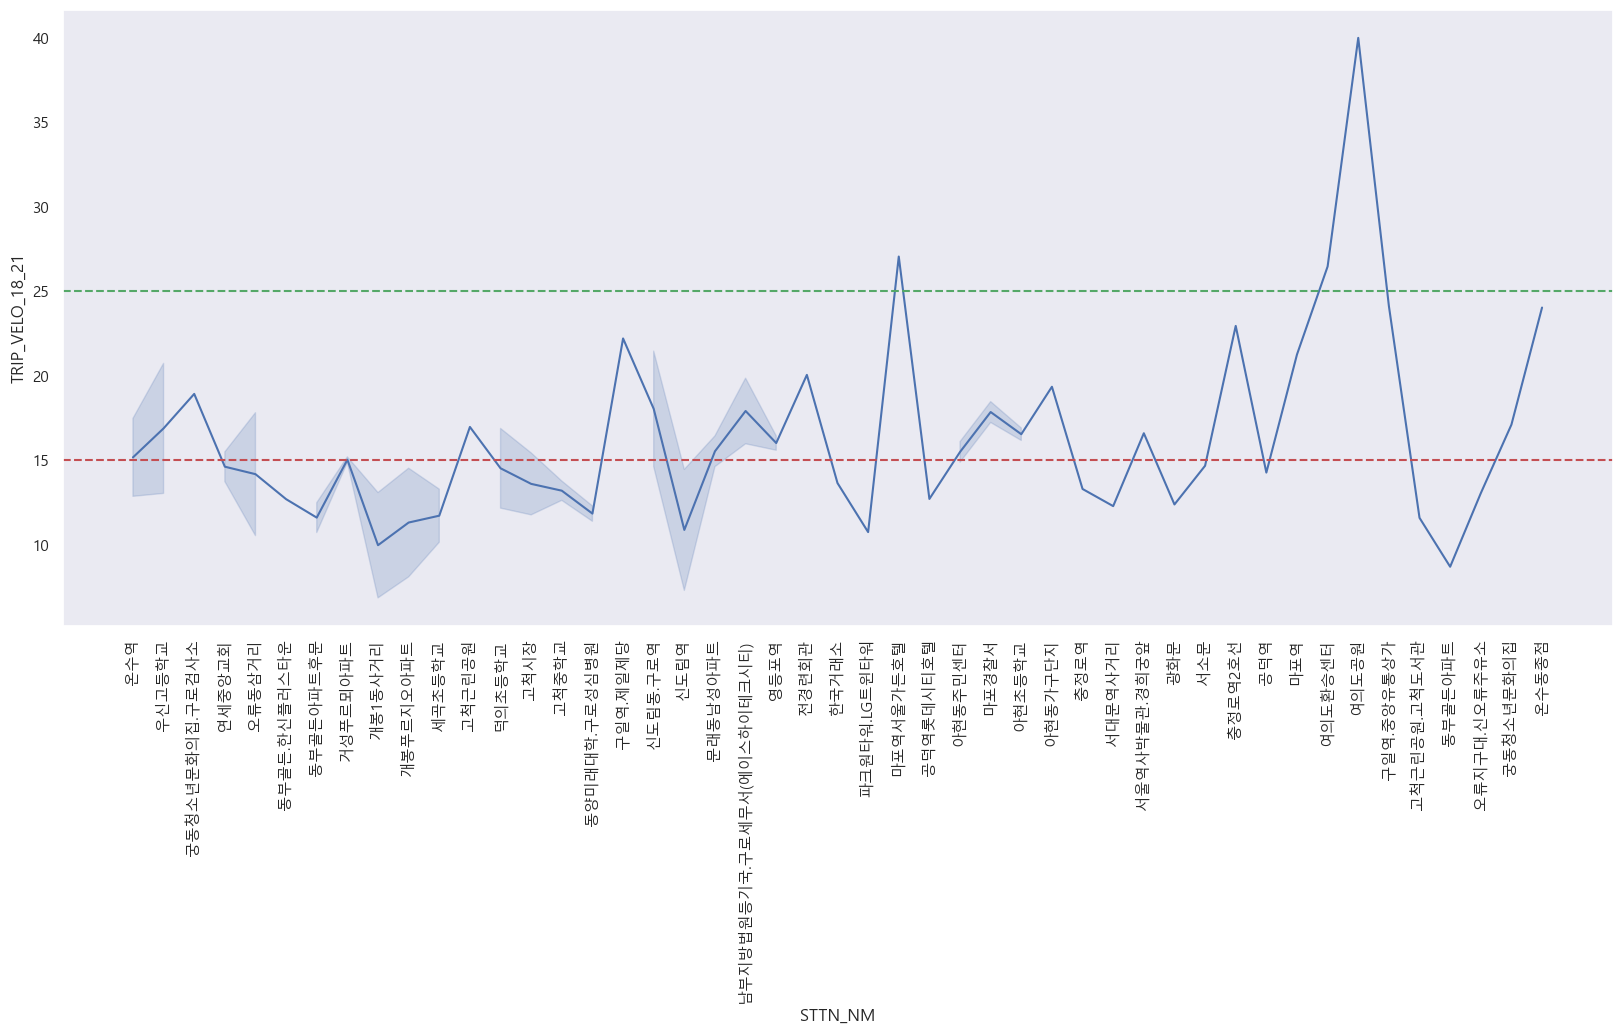

In [14]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=trip_speed_600, x='STTN_NM', y='TRIP_VELO_18_21')
plt.axhline(y=25, color='g', linestyle='--')
plt.axhline(y=15, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.grid(visible=False)
plt.show()